<a href="https://colab.research.google.com/github/rama-challa/500-AI-Machine-learning-Deep-learning-Computer-vision-NLP-Projects-with-code/blob/main/conversational_ai_assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 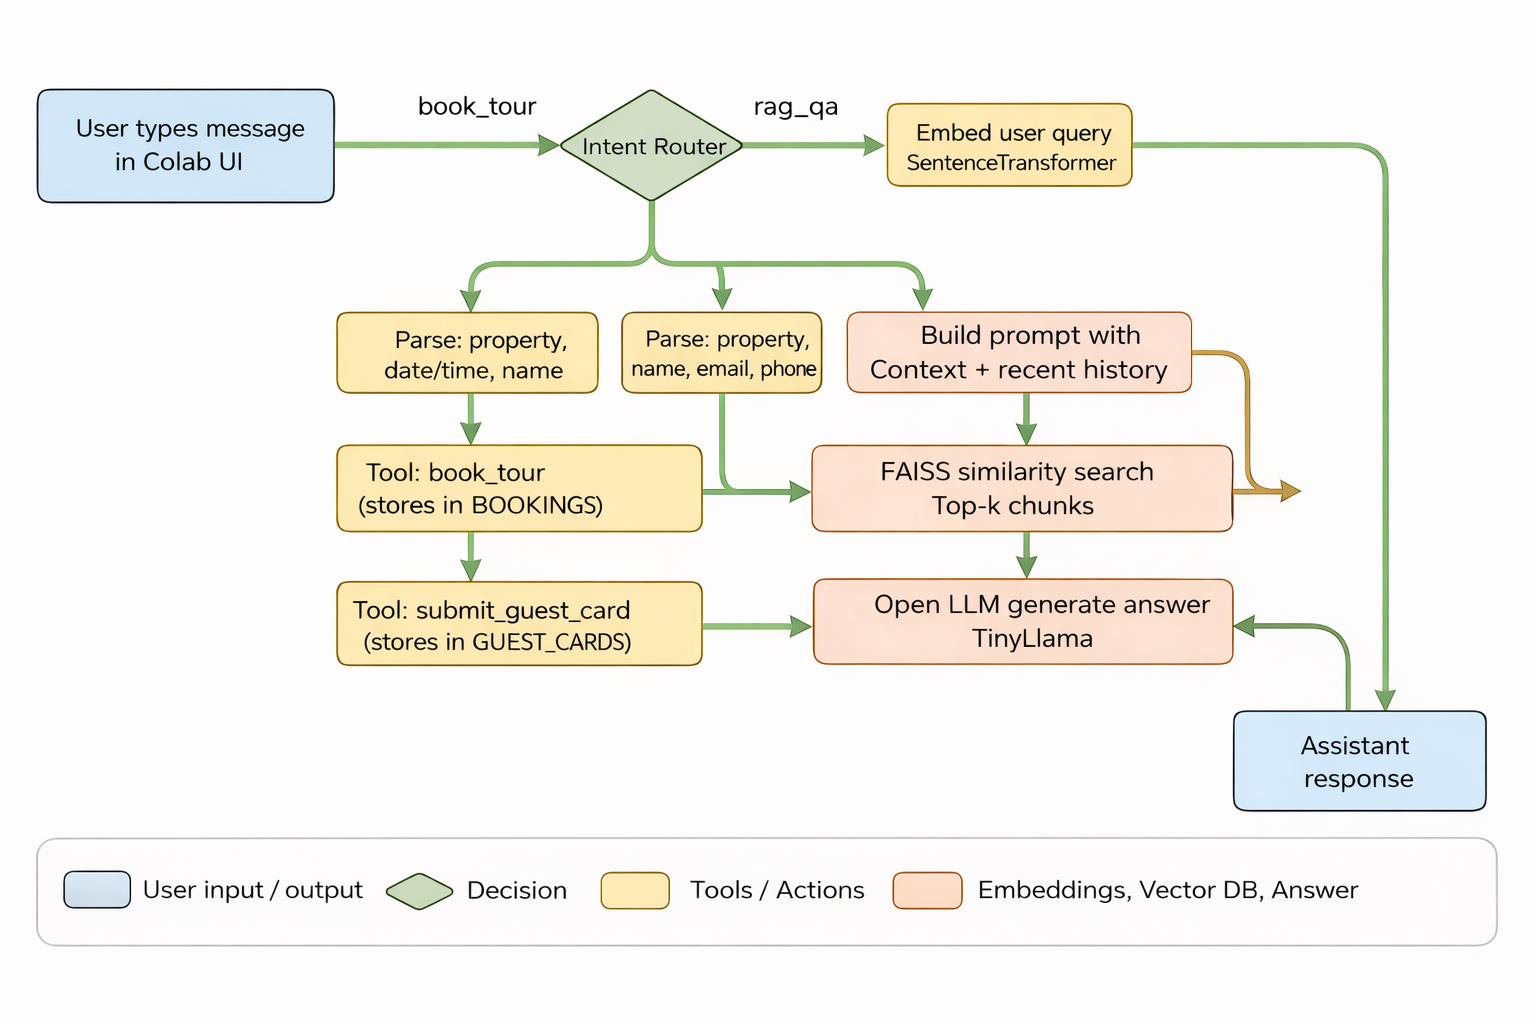

## **Step 1 — Install dependencies**

In [ ]:
!pip -q install transformers accelerate sentence-transformers faiss-cpu ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.1 MB/s eta 0:00:00


## **Step 2 — Imports + small utilities**

In [ ]:
import re
import numpy as np
import faiss
from dataclasses import dataclass
from typing import List, Dict, Tuple

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

import ipywidgets as widgets
from IPython.display import display, Markdown

# **Step 3 — Create a tiny “property knowledge base”**

In [ ]:
PROPERTY_DOCS = [
    {
        "id": "prop_riverside",
        "text": """
Property: Riverside Apartments (Piscataway, NJ)
Amenities: 24/7 gym, seasonal pool, pet-friendly (cats/dogs with fee), parking, laundry.
Tour hours: Mon-Sat 10am-6pm.
Availability: 1BR from Jan 10, rent $2350; 2BR from Feb 1, rent $2950.
Leasing: $50 application fee. Security deposit depends on credit.
"""
    },
    {
        "id": "prop_midtown",
        "text": """
Property: Midtown Lofts (Newark, NJ)
Amenities: rooftop lounge with grills, coworking space, fast Wi-Fi, package room.
Tour hours: Mon-Fri 9am-5pm.
Availability: Studio from Jan 5, $1950; 1BR from Jan 20, $2450.
Leasing: 12-18 month leases. Pet policy: cats allowed, dogs case-by-case.
"""
    },
    {
        "id": "prop_harbor",
        "text": """
Property: Harbor Heights (Jersey City, NJ)
Amenities: concierge, EV charging, fitness studio, bike storage.
Tour hours: Tue-Sun 11am-7pm.
Availability: 2BR from Jan 15, $3400.
Leasing: income verification required; typically 40x rent guideline.
"""
    },
]

def chunk_text(text: str, max_chars: int = 450) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    chunks = []
    start = 0
    while start < len(text):
        chunks.append(text[start:start+max_chars])
        start += max_chars
    return chunks

# **Step 4 — Build embeddings + FAISS vector DB**

In [ ]:
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Build chunks
chunks = []
chunk_meta = []
for d in PROPERTY_DOCS:
    for c in chunk_text(d["text"]):
        chunks.append(c)
        chunk_meta.append({"doc_id": d["id"]})

emb = embedder.encode(chunks, normalize_embeddings=True)
emb = np.array(emb, dtype="float32")

# FAISS index
dim = emb.shape[1]
index = faiss.IndexFlatIP(dim)  # cosine similarity if normalized
index.add(emb)

def retrieve(query: str, k: int = 3) -> List[Tuple[str, Dict, float]]:
    q = embedder.encode([query], normalize_embeddings=True).astype("float32")
    scores, idxs = index.search(q, k)
    results = []
    for score, idx in zip(scores[0], idxs[0]):
        results.append((chunks[idx], chunk_meta[idx], float(score)))
    return results

# **Step 5 — Load a free open-source LLM**

In [ ]:
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto"
)

generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=220,
    do_sample=True,
    temperature=0.7,
    top_p=0.9
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cpu


# **Step 6 — Minimal “tools” (book tour + guest card)**

In [ ]:
BOOKINGS = []
GUEST_CARDS = []

def tool_book_tour(property_name: str, date_time: str, name: str = "") -> str:
    BOOKINGS.append({"property": property_name, "datetime": date_time, "name": name})
    return f"✅ Booked a tour at **{property_name}** for **{date_time}**" + (f" under **{name}**." if name else ".")

def tool_submit_guest_card(property_name: str, name: str, email: str = "", phone: str = "") -> str:
    GUEST_CARDS.append({"property": property_name, "name": name, "email": email, "phone": phone})
    return f"✅ Guest card submitted for **{name}** at **{property_name}**."

# **Step 7 — Router: decide between “RAG answer” vs “tool action”**

In [ ]:
def detect_intent(text: str) -> str:
    t = text.lower()
    if any(x in t for x in ["book", "schedule", "tour", "appointment", "visit"]) and "tour" in t:
        return "book_tour"
    if any(x in t for x in ["guest card", "guestcard", "contact info", "lead"]) :
        return "guest_card"
    return "rag_qa"

def guess_property(text: str) -> str:
    t = text.lower()
    if "riverside" in t: return "Riverside Apartments"
    if "midtown" in t: return "Midtown Lofts"
    if "harbor" in t: return "Harbor Heights"
    return ""

def guess_datetime(text: str) -> str:
    # MVP: grab phrases like "tomorrow 3pm" / "friday at 2"
    m = re.search(r"(today|tomorrow|monday|tuesday|wednesday|thursday|friday|saturday|sunday)(.*)$", text.lower())
    return m.group(0) if m else ""

def guess_name(text: str) -> str:
    m = re.search(r"(my name is|i am)\s+([A-Za-z ]{2,30})", text, flags=re.I)
    return m.group(2).strip() if m else ""

def guess_email(text: str) -> str:
    m = re.search(r"[\w\.-]+@[\w\.-]+\.\w+", text)
    return m.group(0) if m else ""

def guess_phone(text: str) -> str:
    m = re.search(r"(\+1[\s-]?)?\(?\d{3}\)?[\s-]?\d{3}[\s-]?\d{4}", text)
    return m.group(0) if m else ""

# **# Step 8 — RAG response function**

In [ ]:
SYSTEM_STYLE = """You are a helpful property management assistant.
Be concise. If you don't know, ask a short follow-up question.
Use the provided context when available.
"""

def rag_answer(user_msg: str, chat_history: List[Tuple[str, str]]) -> str:
    retrieved = retrieve(user_msg, k=3)
    context = "\n\n".join([f"[Context {i+1}]\n{txt}" for i, (txt, meta, score) in enumerate(retrieved)])

    # Make a compact prompt
    history_text = ""
    for u, a in chat_history[-4:]:
        history_text += f"User: {u}\nAssistant: {a}\n"

    prompt = f"""{SYSTEM_STYLE}

{history_text}
User: {user_msg}

Context:
{context}

Assistant:"""

    out = generator(prompt)[0]["generated_text"]
    return out.split("Assistant:")[-1].strip()

# **Step 9 — Orchestrator: one function that runs everything**

In [ ]:
@dataclass
class AssistantState:
    history: List[Tuple[str, str]]

state = AssistantState(history=[])

def assistant_reply(user_msg: str) -> str:
    intent = detect_intent(user_msg)

    if intent == "book_tour":
        prop = guess_property(user_msg)
        dt = guess_datetime(user_msg)
        name = guess_name(user_msg)

        if not prop:
            return "Which property do you want to tour? (Riverside / Midtown / Harbor)"
        if not dt:
            return "What date and time would you like for the tour?"
        return tool_book_tour(prop, dt, name=name)

    if intent == "guest_card":
        prop = guess_property(user_msg)
        name = guess_name(user_msg)
        email = guess_email(user_msg)
        phone = guess_phone(user_msg)

        if not prop:
            return "Which property is this guest card for? (Riverside / Midtown / Harbor)"
        if not name:
            return "What is your full name for the guest card?"
        return tool_submit_guest_card(prop, name, email=email, phone=phone)

    # default: RAG Q&A
    return rag_answer(user_msg, state.history)

# **Step 10 — Simple chat UI in Colab**

In [ ]:
chat_out = widgets.Output(layout={"border": "1px solid #ddd", "padding": "10px", "height": "320px", "overflow_y": "auto"})
inp = widgets.Textarea(
    placeholder="Type a message (ex: What amenities does Riverside have?)",
    layout=widgets.Layout(width="100%", height="70px")
)
send_btn = widgets.Button(description="Send", button_style="primary")

def render(role: str, text: str):
    with chat_out:
        display(Markdown(f"**{role}:** {text}"))

def on_send(_):
    user_msg = inp.value.strip()
    if not user_msg:
        return
    inp.value = ""
    render("You", user_msg)

    ans = assistant_reply(user_msg)
    state.history.append((user_msg, ans))
    render("Assistant", ans)

send_btn.on_click(on_send)

display(chat_out, inp, send_btn)

# Starter message
render("Assistant", "Hi! Ask about amenities/availability, or say 'Book a tour at Riverside tomorrow 3pm'.")

Output(layout=Layout(border='1px solid #ddd', height='320px', overflow_y='auto', padding='10px'))

Textarea(value='', layout=Layout(height='70px', width='100%'), placeholder='Type a message (ex: What amenities…

Button(button_style='primary', description='Send', style=ButtonStyle())